<a href="https://colab.research.google.com/github/erfan7emz/company-name-generator/blob/main/company_name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import csv
%matplotlib inline
words = []
with open('company.csv', 'r') as file:
  csv_reader = csv.DictReader(file)
  for row in csv_reader:
    # if "'" in row['name'] or '"' in row['name'] or '.' in row['name'] :
    if any(c in row['name'] for c in "!%()+=:~'\"./|"):
      pass
      pass
    else:
      words.append(row['name'])

In [46]:
lowercase_words = ''.join(word.lower() for word in words)
chars = sorted(list(set(lowercase_words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: ' ', 2: '&', 3: ',', 4: '-', 5: '0', 6: '1', 7: '2', 8: '3', 9: '4', 10: '5', 11: '6', 12: '7', 13: '8', 14: '9', 15: '@', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'k', 27: 'l', 28: 'm', 29: 'n', 30: 'o', 31: 'p', 32: 'q', 33: 'r', 34: 's', 35: 't', 36: 'u', 37: 'v', 38: 'w', 39: 'x', 40: 'y', 41: 'z', 0: '.'}


In [50]:
len(chars)

41

In [51]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch.lower()]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([66011, 3]) torch.Size([66011])
torch.Size([7964, 3]) torch.Size([7964])
torch.Size([8481, 3]) torch.Size([8481])


In [52]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((42, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 42), generator=g)
b2 = torch.randn(42, generator=g)
parameters = [C, W1, b1, W2, b2]

In [53]:
for p in parameters:
  p.requires_grad = True

In [54]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [55]:
lri = []
lossi = []
stepi = []

In [56]:
for i in range(190000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 42)
  loss = F.cross_entropy(logits, Ytr[ix])
  # below 3 lines are equivalent to cross_entropy
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()

  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.546741008758545


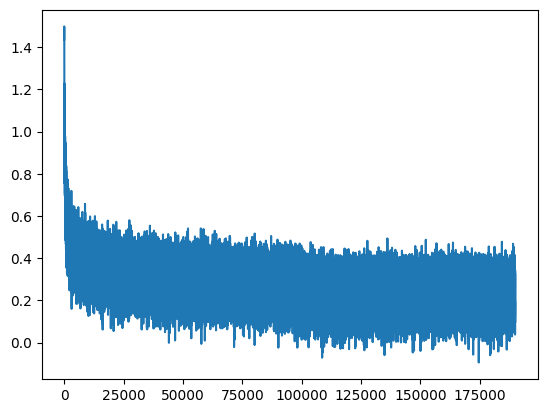

In [57]:
plt.plot(stepi, lossi)

In [58]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 42)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.7412, grad_fn=<NllLossBackward0>)

In [59]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 42)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0071, grad_fn=<NllLossBackward0>)

In [60]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 42)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.9749, grad_fn=<NllLossBackward0>)

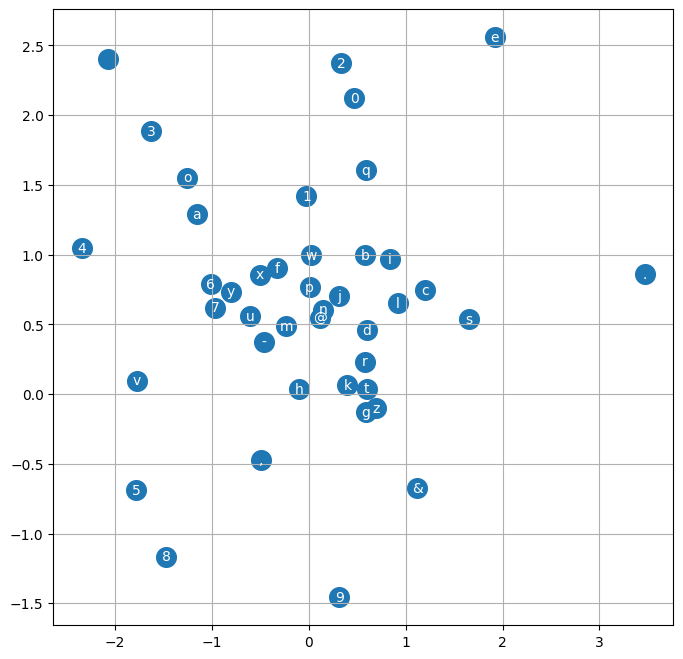

In [61]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [62]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

revelogi -busing.
auco gavent desive locationaleveloyisaare.
grelit ser constrategeck.
mudurtackink relect.
rcial.
waileafe media group.
zsix.
b3 group.
stems service lity.
fivings.
grountegies.
des recore air.
beid vapilastics.
uee nolyformacy therm.
pharmacs syneeoverrealth.
4ded enewseiq farcorp.
inncompanizinity.
erula realth.
perte ferty.
strratglobationsta services.
